This code is inspired from https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/elasticity.plate.html. More precisely, we copied it, than change some code to fit on our diffusion case. It works well without any problem (in any cases the plot seems good)

In [1]:
pip list

Package            Version
------------------ ------------
anyio              4.2.0
astor              0.8.1
asttokens          2.4.1
certifi            2024.2.2
charset-normalizer 2.1.1
colorama           0.4.6
comm               0.2.1
common             0.1.2
contourpy          1.2.0
cycler             0.12.1
debugpy            1.8.1
decorator          5.1.1
DeepXDE            1.10.1
executing          2.0.1
filelock           3.9.0
fonttools          4.48.1
fsspec             2023.4.0
h11                0.14.0
httpcore           1.0.2
httpx              0.26.0
idna               3.6
ipykernel          6.29.2
ipython            8.21.0
jedi               0.19.1
Jinja2             3.1.2
joblib             1.3.2
jupyter_client     8.6.0
jupyter_core       5.7.1
kiwisolver         1.4.5
MarkupSafe         2.1.3
matplotlib         3.8.2
matplotlib-inline  0.1.6
mpmath             1.3.0
nest-asyncio       1.6.0
networkx           3.2.1
numpy              1.26.2
opt-einsum         3.3.0
pac

In [10]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [50]:


# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
else:
  print("/////////////////\n Tensors type on CPU \n///////////////")
# USE_GPU = True
# device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
# print(device)
  
import deepxde as dde
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors


/////////////////
 Tensors type on CPU 
///////////////


In [12]:
##Geometry and boundaries definition
sin = torch.sin
cos = torch.cos

end_time = 1
geom = dde.geometry.Rectangle([0, 0], [1, 1])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_time(x, on_initial):
    # print(x)
    return on_initial and dde.utils.isclose(x[2], 0.0)




C_top_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top)
C_bottom_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom)
C_left_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left)
C_right_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)
initial_condition = dde.icbc.IC(geomtime, lambda x:0, boundary_time)



In [ ]:
#Some tests

Test_tensor = torch.tensor([[1, 2, 6], [3, 4, 8], [5, 6, 1], [4, 6, 1]], dtype=torch.float)
test_pos = torch.tensor([1, 1, 1], dtype=torch.float)
print(Test_tensor-test_pos)
print( torch.linalg.vector_norm(Test_tensor-test_pos, ord=1, dim=1).view(-1,1) )

Test_tensor[:, 0:2]

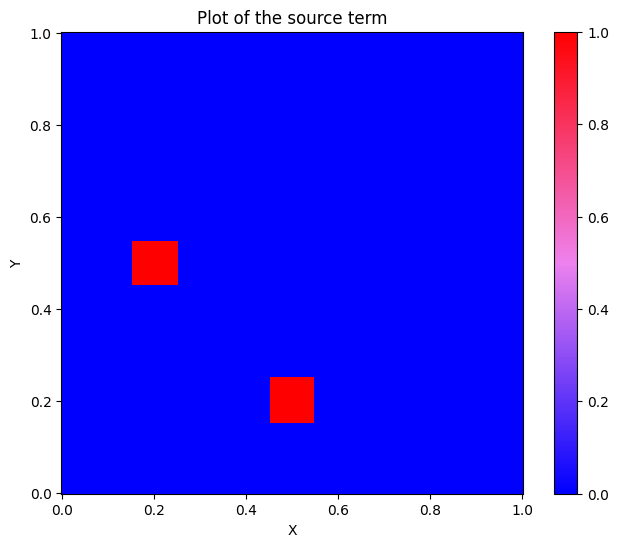

In [103]:
#The definition of the sources and plot of them

#Source places
position_source_1 = torch.tensor([0.2, 0.5], dtype=torch.float) #float type otherwise it raises an error
position_source_2 = torch.tensor([0.5, 0.2], dtype=torch.float) #float type otherwise it raises an error


#Source shapes (change with the width and norm parameters)
def close_to_source(p, position, width):
    '''position: Position of the middle of the source
        width: width of the source'''
    return (torch.isclose(p[:, 0], position[0], atol=width, rtol=0) * torch.isclose(p[:, 1], position[1], atol=width, rtol=0)).view((-1, 1))


def close_to_source_norm(p, position, width, norm):
    '''position: Position of the middle of the source
        width: width of the source'
        norm: order of the L_q norm. input is np.inf to have the infinite norm.
        (https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm)'''
    

    distance_tensor = torch.linalg.vector_norm(p[:, 0:2] - position, ord=norm, dim=1)
    return torch.isclose(distance_tensor, torch.zeros(1, dtype=torch.float), atol=width, rtol=0).view((-1, 1))



#Plot of the Source
x = geom.uniform_points(250 * 250, True)
y_norm = close_to_source_norm(torch.tensor(x), position_source_1, width=1/20, norm=np.inf) + close_to_source_norm(torch.tensor(x), position_source_2, width=1/20, norm=np.inf)

Lx=1
Ly=1

def plot_routine(plot_values, title):
    resolution_mesh = 250
    xi = np.linspace(0, Lx, resolution_mesh)
    yi = np.linspace(0, Ly, resolution_mesh)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata(points=(x[:, 0], x[:, 1]), values=plot_values[:, 0], xi=(xi, yi), method="linear")


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["blue", "violet", "red"]
    )
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()


plot_routine(y_norm, "Plot of the source term")


    

In [120]:
#Pde definition and network construction

#Coefficients of the PDE
D= 0.001
u = np.array([1, 1])


def pde(p, C):
    """residual of the pde
    p contains the spatial coordinates x, y and the time t
    the i-th point (xi, yi, ti) is stored in p in the i-th line and we have
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C corresponds to C(p) the concentration at p"""

    dC_x = dde.grad.jacobian(C, p, j=0)
    dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)



 
    return (
        - dC_t
        - u[0] * dC_x
        - u[1] * dC_y
        + D * (dC_xx + dC_yy)  
        + close_to_source_norm(p, position=position_source_1, width=1/10, norm=np.inf)*1.0
    )


data = dde.data.TimePDE(
    geomtime,
    pde,
    [C_top_bc,
     C_bottom_bc,
     C_left_bc,
     C_right_bc,
     initial_condition,
    ],
    num_domain=500,
    num_boundary=500,
    num_initial = 200,
    num_test=100,
)

layers = [3] + [40] *3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layers, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000244 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.86e-01, 4.40e-02, 5.59e-02, 2.29e-02, 7.72e-02, 6.45e-03]    [2.37e-01, 4.40e-02, 5.59e-02, 2.29e-02, 7.72e-02, 6.45e-03]    []  
1000      [2.31e-02, 4.95e-05, 2.04e-05, 8.22e-05, 4.69e-05, 4.17e-05]    [5.43e-02, 4.95e-05, 2.04e-05, 8.22e-05, 4.69e-05, 4.17e-05]    []  
2000      [2.19e-02, 8.11e-05, 2.16e-05, 1.12e-04, 4.98e-05, 8.51e-05]    [5.09e-02, 8.11e-05, 2.16e-05, 1.12e-04, 4.98e-05, 8.51e-05]    []  
3000      [6.27e-03, 3.09e-04, 3.07e-05, 2.56e-04, 1.18e-05, 2.93e-04]    [3.50e-02, 3.09e-04, 3.07e-05, 2.56e-04, 1.18e-05, 2.93e-04]    []  
4000      [5.53e-03, 2.94e-04, 9.28e-06, 2.00e-04, 3.67e-06, 2.95e-04]    [3.76e-02, 2.94e-04, 9.28e-06, 2.00e-04, 3.67e-06, 2.95e-04]    []  
5000      [5.27e-03, 4.12e-04, 1.02e-05, 1.58e-04, 2.00e-05, 2.99e-04]

In [121]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors

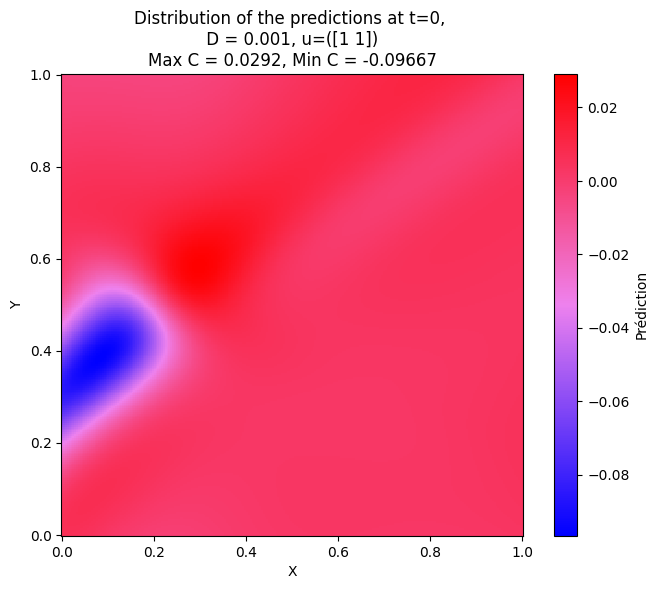

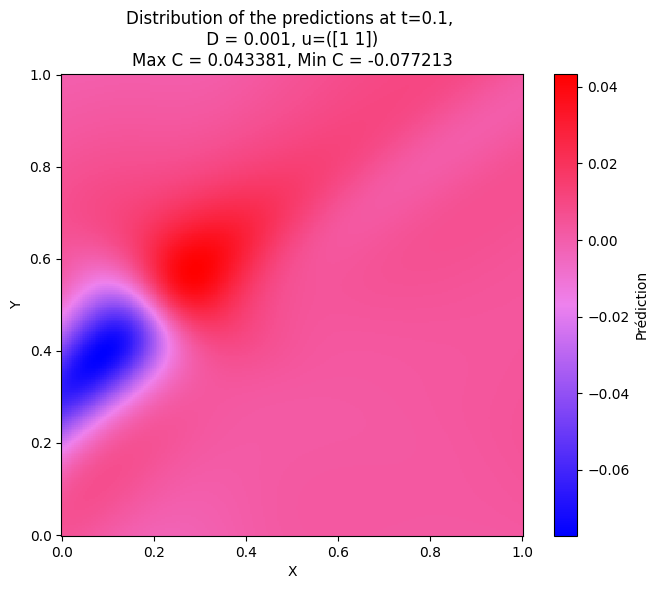

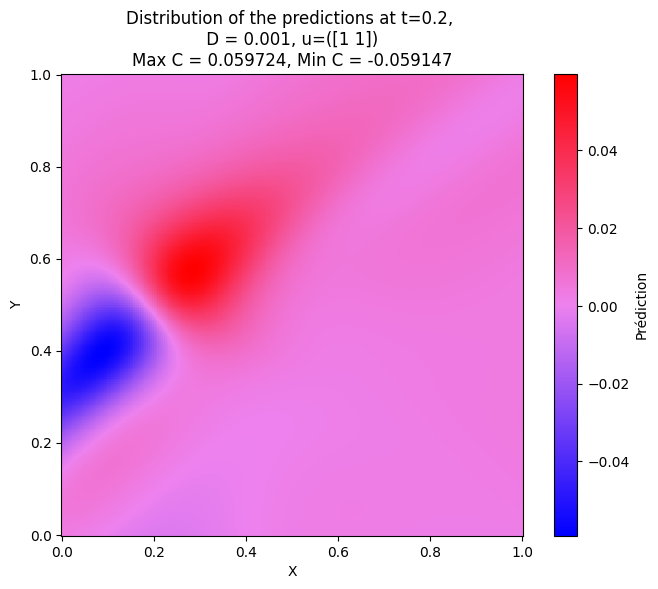

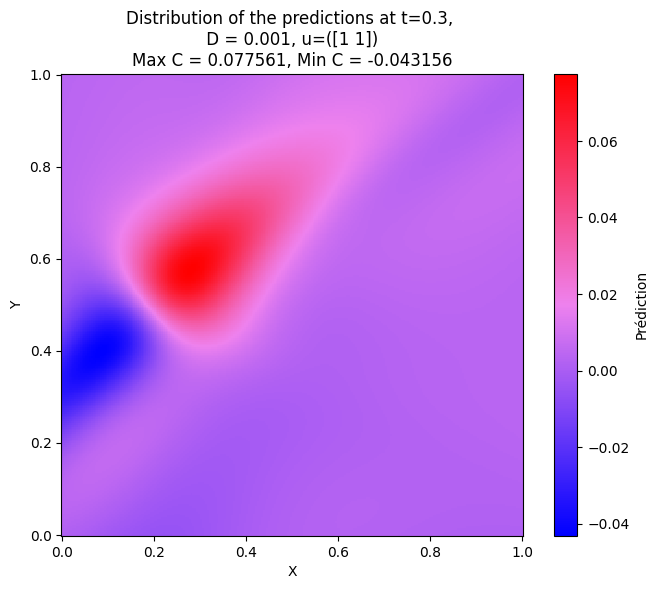

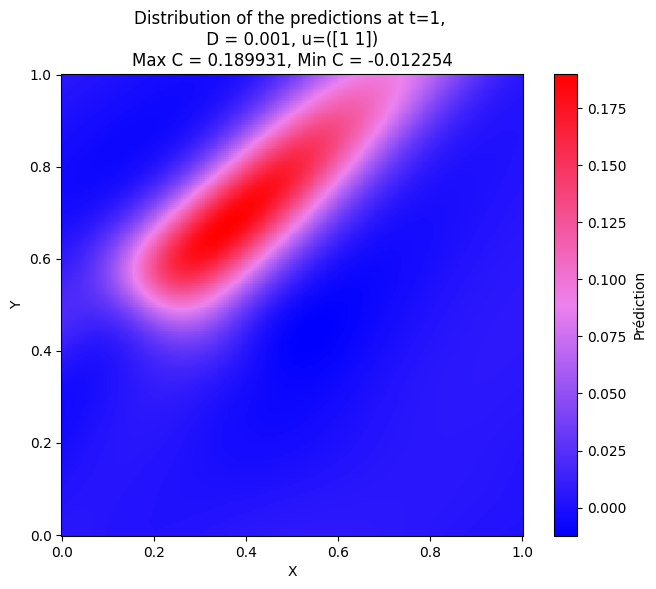

In [122]:
#Code Arnaud
# Test: on affiche le resultat au temps t
Lx=1
Ly=1

time_list = [0, 0.1, 0.2, 0.3, 1]
x = geom.uniform_points(250 * 250, True)
C_max = 0.7 #Max in absolute value to scale the color of the graph
Use_max = False
resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)


for t in time_list:
    p = np.c_[x, np.array([t] * x.shape[0])]
    y = model.predict(p)

    zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

    plt.figure(figsize=(8, 6))
    if Use_max:
        plt.pcolormesh(xi, yi, zi, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
    else:
        plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar(label="Prédiction")
    plt.xlabel("X")
    plt.ylabel("Y")
    title_plot = "Distribution of the predictions " + "at t={time}, \n D = {Diffusion}, u=({advection}) \n" + "Max C = {max}, Min C = {min}"
    plt.title(title_plot.format(time=t, Diffusion = D, advection = u,
                                                         max = int(np.max(y)*10e5)/10e5, min = int(np.min(y)*10e5)/10e5))

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()
    

Some remarks on the computation of the solution and the plot:
*  In "y = model.predict(p, operator=pde)", the "operator = pde" part gives weird results so we don't write it. 
*  The plot with constant Concentration scale hides the diffusion when there's a high cocentration variation. 

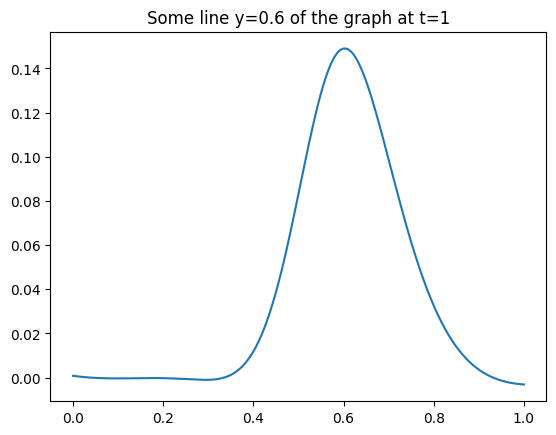

In [16]:
#Verification on some t fixed and y fixed line of the plot

y = 0.6
x = np.linspace(0, 1, 1000)
t = 1

P = np.array([[x, y, t] for x in np.linspace(0, 1, 1000)])
C = model.predict(P)

plt.plot(x, C)
plt.title("Some line y={ordinate} of the graph at t={time}".format(time=t, ordinate = y))
plt.show()
